link for data
https://github.com/sashaboriskin/university_data_analisys/tree/main/3_lesson

link for vk bot
https://vk.com/club222791603

In [126]:
import random
import logging
from logging import FileHandler, Formatter
import sys

import pandas as pd
import vk_api 
from vk_api.longpoll import VkLongPoll, VkEventType
from vk_api.utils import get_random_id
from vk_api.keyboard import VkKeyboard, VkKeyboardColor

In [127]:
# Подключение к вк
group_key = 'vk1.a.IozVEQToDm3N8sOnFPt7xecrQTGnmCHM-BeOuM0gl-PcbmJxqtw4P1r-wa7rkno55vyQTu-2yMvDu6etw11kq7WQIf7cEon_Q9trQp5uwIsejUgw0VVh2yZWNB9SiIYjXJ72EBY_rgwDOYb5L3qM8ojj6wQDdoXO81qak5HH8J3CmPpN8u3167TxIB7lpeZP2OzYyO97QNhCg7d6T8PA8A'
vk_session = vk_api.VkApi(token = group_key)
longpoll = VkLongPoll(vk_session)
vk = vk_session.get_api()

# Название файлов с вопросами
quiz_files = {
    'свойства воздуха': 'свойства воздуха.csv',
}

materials = pd.read_csv('data/материалы.csv', delimiter=';')

# Настройки клавиатуры
keyboard = VkKeyboard(one_time=False)
keyboard.add_button('свойства воздуха', color=VkKeyboardColor.SECONDARY)
keyboard.add_button('статистика', color=VkKeyboardColor.POSITIVE)

# Структура (пользователь -> статистика)
global user_stats
user_stats = dict()

In [128]:
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("urllib3").propagate = False

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

pd.DataFrame({"time": [], "log_type": [], "ation_type": [], "user_id": []}).to_csv("logs.csv", sep="\t", index=False)

handler = FileHandler(filename="logs.csv")
handler.setFormatter(Formatter(fmt='%(asctime)s\t%(levelname)s\t%(message)s'))
logger.addHandler(handler)

In [129]:
def define_action(event, commands):
    for i in range(len(commands)):
        if event.text.startswith(comands[i]):
            return i

    return -1

In [130]:
# Отправляем статистику пользователя
def check_stats(user_id):
    if user_stats[user_id]['number_of_all_answers'] != 0:
        message = f"""Статистика ваших ответов:
            Правильных: {user_stats[user_id]['number_of_right_answers']}
            Всего: {user_stats[user_id]['number_of_all_answers']}
            Процент: {user_stats[user_id]['number_of_right_answers']/user_stats[user_id]['number_of_all_answers'] * 100}
        """
        vk.messages.send(
            user_id=user_id,
            message=message,
            random_id=0
        )
    else:
        vk.messages.send(
            user_id=user_id,
            message='Вы еще не прошли ни одной викторины',
            random_id=0
        )

In [131]:
def try_to_guess(user_id, right_answer_index):
    is_right_answer = True
    for answer_event in longpoll.listen():
        if answer_event.type == VkEventType.MESSAGE_NEW and answer_event.to_me:
            try:
                user_answer = int(answer_event.text)
            except ValueError:
                logger.critical(f'неправильный формат данных\t{event.user_id}')
            
            if user_answer not in (1, 2, 3, 4):
                error_message = 'неправильный формат ответа. ответ должен быть цифрой от 1 до 4'
                logger.error(f'{error_message}\t{event.user_id}')
                vk.messages.send(
                    user_id=user_id,
                    message=error_message,
                    random_id=0
                )
            # user_stats[user_id]['number_of_all_answers'] += 1

            if user_answer != right_answer_index:
                is_right_answer = False
                logger.debug(f'юзер выбрал неправильный ответ\t{event.user_id}')
            break
            
    return is_right_answer, user_answer

In [132]:
def quiz(text, user_id, materials):
    # Пользователь выбрал викторину, начинаем вопросы
    quiz_name = text
    df = pd.read_csv(f'data/{quiz_files[quiz_name]}', encoding='utf-8', delimiter=';')
    all_questions = df['формулировка вопроса'].unique()
  
    for question in all_questions:
        
        possible_answers = list(df[df['формулировка вопроса']==question]['вариант ответа'])
        right_answer_text = df[df['формулировка вопроса']==question] \
           [df['правильность']==1]['вариант ответа'].item()
        right_answer_index = possible_answers.index(right_answer_text) + 1

        message = f'''{question} 
        1. {possible_answers[0]} 
        2. {possible_answers[1]}
        3. {possible_answers[2]}
        4. {possible_answers[3]}'''

        vk.messages.send(
                user_id=user_id,
                message=message,
                random_id=0
            )
       
        is_right_answer, user_answer = try_to_guess(user_id, right_answer_index)
        user_stats[user_id]['number_of_all_answers'] += 1
        logging.info(f'stats: number_of_all_answers+=1\t{event.user_id}')
        
        if not is_right_answer:
                material_message = materials[materials['название темы']==quiz_name]['ссылка на материал'].item()
                logging.info(f'вопрос: {question}, ответ: {user_answer}, {is_right_answer}')
                vk.messages.send(
                            user_id=user_id,
                            message=f'ответ неверный. ссылка для повторения: {material_message}',
                            random_id=0
                        )
                break
        else:
            user_stats[user_id]['number_of_right_answers'] += 1
            logging.info(f'вопрос: {question}, ответ: {user_answer}, {is_right_answer}\t{event.user_id}')
            logging.info(f'stats: number_of_right_answers+=1\t{event.user_id}')
            vk.messages.send(
                        user_id=user_id,
                        message=f'ответ верный. следующий вопрос',
                        random_id=0
                    )
            continue
        vk.messages.send(
                        user_id=user_id,
                        message='вопросы закончились! ждите новых викторин! ',
                        random_id=0
                    )
        logging.info(f'вопросы закончились\t{event.user_id}')

In [ ]:
for event in longpoll.listen():
    if event.type == VkEventType.MESSAGE_NEW and event.to_me:
        user_id = event.user_id
        text = event.text.lower()
        # Переменные для подсчета статистики
        if not user_id in user_stats.keys(): 
            
            user_stats[user_id] = {
                'number_of_right_answers': 0,
                'number_of_all_answers': 0
            }
        
        if text == 'привет':   
            logger.info(f'приветсвенное сообщение\t{event.user_id}')
            print('info, приветсвенное сообщение')
            vk.messages.send(
                user_id=user_id,
                message="Выберите викторину:",
                random_id=0,
                keyboard=keyboard.get_keyboard()
            )
            
        elif text in quiz_files.keys():
            logger.info(f'начало викторины\t{event.user_id}')
            print('info, начало виуторины')
            quiz(text, user_id, materials)
                        
        elif text == 'статистика':
            logger.info(f'вызов и просмотр статистики\t{event.user_id}')
            print('info, просмотр статистики')
            check_stats(user_id)
            
        else: 
            logger.error(f'неизвестная команда от пользотвателя\t{event.user_id}')
            print('error, unknown command')
            vk.messages.send(
                    user_id=user_id,
                    message='Неизвестная команда',
                    random_id=0
                )

In [123]:
DF = pd.read_csv('logs.csv', delimiter='\t')
DF.rename(columns={'user_id': 'case:concept:name', 
                  'ation_type': 'concept:name', 
                  'time': 'time:timestamp'}, inplace=True)

In [124]:
DF

,time:timestamp,log_type,concept:name,case:concept:name
0,"2023-10-08 22:07:16,640",INFO,приветсвенное сообщение,101180492.0
1,"2023-10-08 22:07:23,767",INFO,начало викторины,101180492.0
2,"2023-10-08 22:07:27,690",INFO,stats: number_of_all_answers+=1,101180492.0
3,"2023-10-08 22:07:27,690",INFO,"вопрос: Что такое воздух?, ответ: 1, True",101180492.0
4,"2023-10-08 22:07:27,691",INFO,stats: number_of_right_answers+=1,101180492.0
5,"2023-10-08 22:07:30,447",ERROR,неправильный формат ответа. ответ должен быть ...,101180492.0
6,"2023-10-08 22:07:30,559",INFO,stats: number_of_all_answers+=1,101180492.0
7,"2023-10-08 22:07:30,561",INFO,вопрос: Какое из веществ входит в основной сос...,NaN
8,"2023-10-08 22:07:36,364",INFO,вызов и просмотр статистики,101180492.0


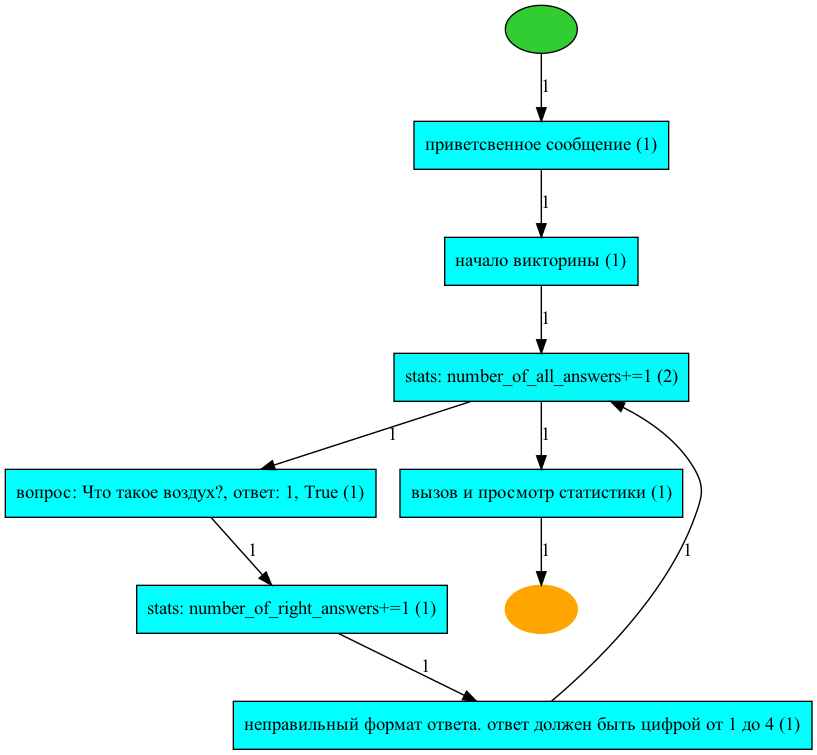

In [125]:
from pm4py.objects.conversion.log import converter as log_conv
log = log_conv.apply(DF)

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(log)

from pm4py.visualization.heuristics_net import visualizer as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)